# Visualize your location history with Python and Leaflet

See [this blog post](http://geoffboeing.com/2016/06/mapping-everywhere-ever-been/) for my full write-up of this project.

This project collects, clusters, geocodes, merges, and now visualizes location history data from Foursquare, Google, and a spreadsheet of prior travels. It produces maps with Python's matplotlib basemap and with Leaflet.

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, json, math, random
from datetime import datetime as dt
from mpl_toolkits.basemap import Basemap
from IPython.display import IFrame
%matplotlib inline

## First, load the 3 data sets

In [2]:
# load the clustered/reduced and reverse-geocoded google location history data
df_ggl = pd.read_csv('data/google-location-history.csv', encoding='utf-8')
cols_to_retain = ['datetime', 'neighborhood', 'city', 'state', 'country', 'lat', 'lon']
df_ggl = df_ggl[cols_to_retain]
print('There are {:,} rows in the google data set'.format(len(df_ggl)))
df_ggl.head()

There are 4,149 rows in the google data set


,datetime,neighborhood,city,state,country,lat,lon
0,2013-10-06 21:23:49,Central Berkeley,Berkeley,California,United States,37.863151,-122.273774
1,2015-05-23 01:15:54,Gucheng Qu,Lijiang Shi,Yunnan Sheng,China,26.878139,100.242087
2,2014-06-07 08:07:51,NaN,Tübingen,Baden-Württemberg,Germany,48.522827,9.054906
3,2014-12-26 08:06:56,NaN,Chandler,Arizona,United States,33.309692,-111.902135
4,2016-05-29 16:25:01,NaN,Redfern,New South Wales,Australia,-33.893208,151.215002


In [3]:
df_fsq = pd.read_csv('data/foursquare-location-history.csv', encoding='utf-8')
print('There are {:,} rows in the foursquare data set'.format(len(df_fsq)))
df_fsq.head()

There are 2,209 rows in the foursquare data set


,category,city,country,lat,lon,state,venue_name,datetime,weekday,hour,month
0,Rest Area,Red Bluff,United States,40.269986,-122.270284,CA,Herbert S Miles Rest Area Southbound,2016-08-08 16:22,0,16,2016-08
1,Border Crossing,Dorris,United States,42.003387,-121.889019,CA,California-Oregon Border on US 97,2016-08-08 13:57,0,13,2016-08
2,Brewery,Klamath Falls,United States,42.227988,-121.776505,OR,Klamath Basin Brewing Co.,2016-08-08 12:44,0,12,2016-08
3,Brewery,Klamath Falls,United States,42.228001,-121.776495,OR,The Creamery Brewpub & Grill,2016-08-08 12:44,0,12,2016-08
4,Rest Area,NaN,United States,43.177635,-121.786072,Oregon,Beaver Marsh Rest Area,2016-08-08 10:35,0,10,2016-08


In [4]:
# load the geocoded previous travel history (places visited prior to smartphone/gps)
df_pre = pd.read_csv('data/previous-travels-geocoded.csv', encoding='utf-8')
print('There are {:,} rows in the previous travels data set'.format(len(df_pre)))
df_pre.head()

There are 318 rows in the previous travels data set


,place,city,state,country,date,lat,lon
0,NaN,Bach,NaN,Austria,2009-06,47.263263,10.397746
1,Hundertwasserhaus,Vienna,NaN,Austria,2009-06,48.207222,16.394167
2,Schonbrunn Palace,Vienna,NaN,Austria,2009-06,48.184865,16.312240
3,St. Stephen's Cathedral,Vienna,NaN,Austria,2009-06,48.208494,16.373156
4,NaN,Siem Reap,NaN,Cambodia,2011-02,13.367097,103.844813


## Now, map the data sets

In [5]:
# define map colors
land_color = '#f5f5f3'
water_color = '#cdd2d4'
coastline_color = '#f5f5f3'
border_color = '#bbbbbb'
meridian_color = '#eaeaea'
marker_fill_color = '#0033cc'
marker_edge_color = 'None'

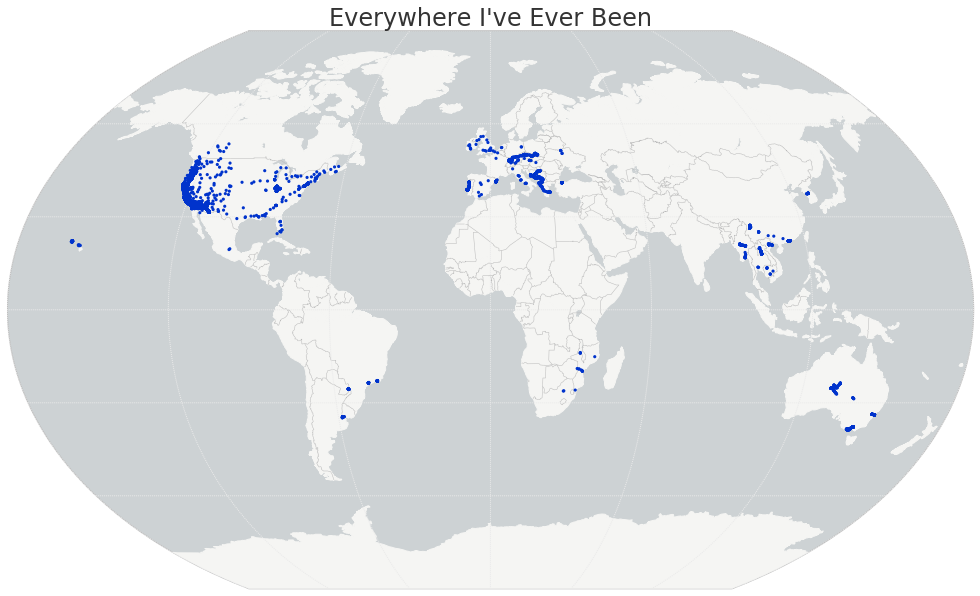

In [6]:
# create the plot
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, axisbg='#ffffff', frame_on=False)
ax.set_title('Everywhere I\'ve Ever Been', fontsize=24, color='#333333')

# draw the basemap and its features
m = Basemap(projection='kav7', lon_0=0, resolution='l', area_thresh=10000)
m.drawmapboundary(color=border_color, fill_color=water_color)
m.drawcoastlines(color=coastline_color)
m.drawcountries(color=border_color)
m.fillcontinents(color=land_color, lake_color=water_color)
m.drawparallels(np.arange(-90., 120., 30.), color=meridian_color)
m.drawmeridians(np.arange(0., 420., 60.), color=meridian_color)

# project our points from each dataset then concatenate and scatter plot them
for df in [df_ggl, df_fsq, df_pre]:
    x, y = m(df['lon'].values, df['lat'].values)
    m.scatter(x, y, s=10, color=marker_fill_color, edgecolor=marker_edge_color, alpha=1, zorder=3)

# show the map
plt.savefig('images/location_history_world_map.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Next, process the data and save to geojson for leaflet web mapping

In [7]:
# de-duplicate rows with identical neighborhood, city, and state
df_ggl = df_ggl.drop_duplicates(subset=['neighborhood', 'city', 'state'], keep='first')
print(len(df_ggl))

1362


In [8]:
df_ggl = df_ggl.rename(columns={'neighborhood':'place'})
df_fsq = df_fsq.rename(columns={'venue_name':'place'})
df_pre = df_pre.rename(columns={'date':'datetime'})

In [9]:
df_combined = pd.concat([df_pre, df_ggl, df_fsq], axis=0)
df_combined['year'] = df_combined['datetime'].str[0:4]
df_combined['year'] = df_combined['year'].str.replace('1995', '').fillna('')
df_combined = df_combined[['place', 'city', 'state', 'country', 'year', 'lat', 'lon']]
df_combined.tail()

,place,city,state,country,year,lat,lon
2204,Delirium,San Francisco,CA,United States,2012,37.764809,-122.422843
2205,Gestalt,San Francisco,CA,United States,2012,37.764852,-122.423336
2206,Monk’s Kettle,San Francisco,CA,United States,2012,37.764803,-122.422926
2207,MacArthur BART Station,Oakland,CA,United States,2012,37.829387,-122.266974
2208,Suya African Caribbean Grill,Berkeley,CA,United States,2012,37.870350,-122.265979


In [10]:
def get_description(row):
    fields = row[['place', 'city', 'state', 'country']].dropna().drop_duplicates()
    if len(fields) == 1:
        # if there's only 1 field, just return it
        return fields.iloc[0]
    elif len(fields) == 2:
        # if there are 2, return them with a line break between
        return fields.iloc[0] + '<br />' + fields.iloc[1]
    elif len(fields) == 3:
        # if there are 3, return the city/state comma-separated, then country after a line break
        return fields.iloc[0] + ', ' + fields.iloc[1] + '<br />' + fields.iloc[2]
    elif len(fields) == 4:
        # if there are 4, return place then line break, then city/state, line break, then country
        return fields.iloc[0] + '<br />' + fields.iloc[1] + ', ' + fields.iloc[2] + '<br />' + fields.iloc[3]

In [11]:
df_combined['desc'] = df_combined.apply(get_description, axis=1)

In [12]:
# round lat-long to 7 decimal points (to prevent fluky floating point .000000000001 stuff) to reduce js data file size
df_combined['lat'] = df_combined['lat'].round(7)
df_combined['lon'] = df_combined['lon'].round(7)

In [13]:
def df_to_geojson(df, properties=[], lat='lat', lon='lon'):
    geojson = {'type':'FeatureCollection', 'features':[]}
    for _, row in df.iterrows():
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'Point',
                               'coordinates':[]}}
        feature['geometry']['coordinates'] = [row[lon],row[lat]]
        for prop in properties:
            feature['properties'][prop] = row[prop] if prop in row else None
        geojson['features'].append(feature)
    return geojson

In [14]:
cols_to_save = ['desc', 'year']
geojson = df_to_geojson(df_combined, cols_to_save)

In [15]:
output_filename = 'leaflet/location-dataset.js'
with open(output_filename, 'w') as output_file:
    output_file.write('var dataset = {};'.format(json.dumps(geojson, separators=(',',':'))))
print('{:,} geotagged features saved to file'.format(len(geojson['features'])))

3,889 geotagged features saved to file


In [16]:
# show the iframe of the leaflet web map here
IFrame('leaflet/location-map.html', width=600, height=400)

To see the final product live, visit: http://geoffboeing.com/2016/06/mapping-everywhere-ever-been/